
# Contents
1. Comparison of methods
   
   1.1 Prediction using theory

   1.2 NN

    1.2.1 NN with theory-based features

    1.2.2 NN with augmented features

   1.3 Gradient Boost

    1.3.1 GB with theory-based features
    
2. Summary of findings
3. Next steps

In [1]:
import sys
import os
import time
import glob
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
from torch import nn

sys.path.append(os.path.abspath('..'))
import src.utils.garmin_utils as garmin_utils
import src.utils.matfcns as matfcns

In [2]:
def get_error_df(y_pred_train, y_train, y_pred, y_test, estim_name):
    mse = [mean_squared_error(y_pred_train, y_train), mean_squared_error(y_pred, y_test)]
    mae = [mean_absolute_error(y_pred_train, y_train), mean_absolute_error(y_pred, y_test)]
    results = pd.DataFrame({'dataset': [f'{estim_name}_train', f'{estim_name}_test'], 'MAE':mae, 'MSE': mse})
    results = results.set_index('dataset')
    return results

def plot_actual_vs_predicted_timeseries(y_pred, y_test, timestamp, title):
    data = [
        go.Scatter(x =timestamp, y=y_test, name='actual'),
        go.Scatter(x =timestamp, y=y_pred, name='predicted')
    ]
    fig = go.Figure(data=data)
    fig.update_layout(
        title=title,
        yaxis_title='power (watts)',
    )
    fig.show()

def plot_actual_vs_predicted_scatter(y_pred, y_test, title, xy_title=['actual', 'predicted']):
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel(xy_title[0])
    plt.ylabel(xy_title[1])
    plt.title(title)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
    plt.show()

def post_prediction_adjustment(y_pred, cadence):
    mask = np.array(cadence) == 0
    y_pred[mask] = 0
    mask = y_pred < 0
    y_pred[mask] = 0
    return y_pred


In [27]:
processed_file = '../data/garmin/processed/eda__raw_all_winsize_50.csv' 
df = pd.read_csv(processed_file)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index(df['timestamp'], inplace=True)
df = df.dropna() # these are introduced by movmean()
df = df[~np.isinf(df['grade'])] # grade can be infty

days = [12, 23, 25, 26, 15]
mask_train = (df['timestamp'].dt.day == days[0]) | (df['timestamp'].dt.day == days[2]) | (df['timestamp'].dt.day == days[3]) | (df['timestamp'].dt.day == days[4])
mask_test  = (df['timestamp'].dt.day == 23) 

timestamp_train = df.loc[mask_train, 'timestamp']
timestamp_test = df.loc[mask_test, 'timestamp']

X = df.drop(['power', 'timestamp', 'position_lat', 'position_long', 'distance', 'd_distance', 'enhanced_altitude'], axis=1)

X_train = X[mask_train]
y_train = df.loc[mask_train, 'power']
X_test  = X[mask_test]
y_test  = df.loc[mask_test, 'power']


DatetimeIndex(['2023-08-23 17:17:26', '2023-08-23 17:17:27',
               '2023-08-23 17:17:28', '2023-08-23 17:17:29',
               '2023-08-23 17:17:30', '2023-08-23 17:17:31',
               '2023-08-23 17:17:32', '2023-08-23 17:17:33',
               '2023-08-23 17:17:34', '2023-08-23 17:17:35',
               ...
               '2023-08-23 19:02:16', '2023-08-23 19:02:17',
               '2023-08-23 19:02:18', '2023-08-23 19:02:19',
               '2023-08-23 19:02:20', '2023-08-23 19:02:21',
               '2023-08-23 19:02:22', '2023-08-23 19:02:23',
               '2023-08-23 19:02:24', '2023-08-23 19:02:25'],
              dtype='datetime64[ns]', name='timestamp', length=4948, freq=None)

# 1 Comparison of methods

## 1.1 Prediction using theory
We derived the following equation in the [previous notebook](part2_power_analysis.ipynb)
$$\begin{equation}\tag{1}P = a\cdot v_{gs}^3 + b\cdot v_{gs}^2 + f(\phi) \cdot v_{gs} + d\end{equation}$$
We craft a new feature set to make use of this equation.

In [40]:
def get_theory_df(df):
    '''
    Extract features to use with equation (1) above. See previous notebook for details.
    '''
    theory_df = pd.DataFrame({
    'cos': np.cos(np.arctan(df['grade']/100)) * df['enhanced_speed'],
    'sin': np.sin(np.arctan(df['grade']/100)) * df['enhanced_speed'],
    'v': df['enhanced_speed'],
    'v^2': np.power(df['enhanced_speed'], 2),
    'v^3': np.power(df['enhanced_speed'], 3)
    })
    return theory_df

def compute_powers(mass, grade, temperature, v_gs, v_hw, Cd=0.63, area=0.5089, Crr=0.005):
    v_as = np.add(v_gs, v_hw)
    rho = matfcns.temperature2density(temperature)

    gravity_force = matfcns.gravityF(grade, mass)
    roll_force = matfcns.roll_resistF(grade, mass, Crr)
    drag_force = matfcns.dragF(v_as, rho, area, Cd)

    d_p = drag_force * v_as
    g_p = gravity_force * v_gs
    r_p = roll_force * v_gs

    return g_p, r_p, d_p

First we compute the purely theoretical 'prediction (application of governing equations)'.

In [5]:
mass = 90
v_hw = 0
grade = X_test['grade']
g_p, r_p, d_p = compute_powers(mass, X_test['grade'], X_test['temperature'], X_test['enhanced_speed'], v_hw)
y_pred_theory = post_prediction_adjustment(g_p+r_p+d_p, X_test['cadence']).values

Then compare it with linear regression based on theory.

In [6]:
X_train_theory = get_theory_df(X_train)
X_test_theory = get_theory_df(X_test)

pipe_linreg = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

pipe_linreg.fit(X_train_theory, y_train)
y_pred = pipe_linreg.predict(X_test_theory)

print('pure theory MAE:', mean_absolute_error(y_pred_theory, y_test))
errors_theory_linreg = get_error_df(pipe_linreg.predict(X_train_theory), y_train, y_pred, y_test, 'theory-linreg')
errors_theory_linreg

pure theory MAE: 25.468604615168857


MAE         MSE
dataset                                   
theory-linreg_train  20.551110  744.953702
theory-linreg_test   19.509578  826.195141

Linear regression with theory-based features outperform the purely theoretical approach, as was to be expected.
We examine a few plots to see if we can improve the estimators.

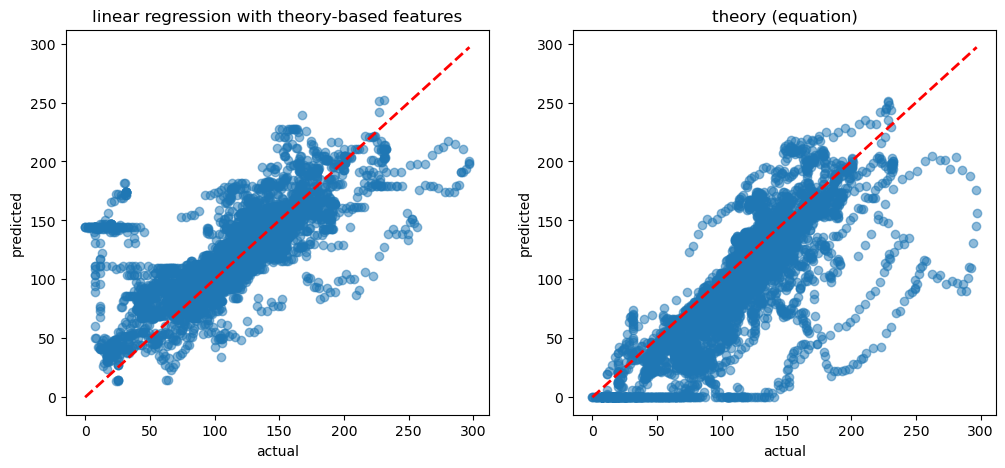

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(y_test, y_pred, alpha=0.5)
axs[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
axs[0].title.set_text('linear regression with theory-based features') 
axs[0].set(xlabel='actual', ylabel='predicted')

axs[1].scatter(y_test, y_pred_theory, alpha=0.5)
axs[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
axs[1].set(xlabel='actual', ylabel='predicted')
axs[1].title.set_text('theory (equation)') 
plt.show()

In [8]:
dts = np.array([
    datetime(2023, 8, 23, 17, 39, 0), datetime(2023, 8, 23, 17, 42, 0),
    datetime(2023, 8, 23, 18, 28, 0), datetime(2023, 8, 23, 18, 37, 0)
])

In [9]:
data = [
    go.Scatter(x =timestamp_test, y=y_test, name='actual'),
    go.Scatter(x =timestamp_test, y=y_pred, name='theory-linreg'),
    go.Scatter(x =timestamp_test, y=y_pred_theory, name='theory')
]
fig = go.Figure(data=data)

fig.add_vline(x=dts[0], line_color='black')
fig.add_vline(x=dts[1], line_color='black')
fig.add_vline(x=dts[2], line_color='fuchsia')
fig.add_vline(x=dts[3], line_color='fuchsia')

fig.update_layout(
    title='linear regression with theory features',
    yaxis_title='power (watts)',
)
fig.show()

Two intervals enclosed by black and fuchsia lines stick out. There are sections within those intervals where predicted values move in the opposite direction of `power`.
We plot data from these intervals to investigate.

In [10]:
df23 = df[df['timestamp'].dt.day == 23]
df23_test = df23[mask_test]
mask_dt1 = np.logical_and(df23['timestamp'] >= dts[0], df23['timestamp'] <= dts[1])
mask_dt2 = np.logical_and(df23['timestamp'] >= dts[2], df23['timestamp'] <= dts[3])

data = [
    go.Scattermapbox(
        lat=df23['position_lat'],
        lon=df23['position_long'],
        mode='markers',
        marker=go.scattermapbox.Marker(color='blue', size=2),
        name='entire route'
    ),
    go.Scattermapbox(
        lat=df23.loc[mask_dt1, 'position_lat'],
        lon=df23.loc[mask_dt1, 'position_long'],
        mode='markers',
        marker=go.scattermapbox.Marker(color='black'),
        name='interval 1'
    ),
    go.Scattermapbox(
        lat=df23.loc[mask_dt2, 'position_lat'],
        lon=df23.loc[mask_dt2, 'position_long'],
        mode='markers',
        marker=go.scattermapbox.Marker(color='fuchsia'),
        name='interval 2'
    )
]
fig = go.Figure(data=data)

fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r":0,"t":0,"l":0,"b":0},
    mapbox=dict(zoom=11.5,
                center=dict(lat=37.42, lon=-122.19)
                ),
    width=800, height=600
)
fig.show()

/tmp/ipykernel_27682/1974182311.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



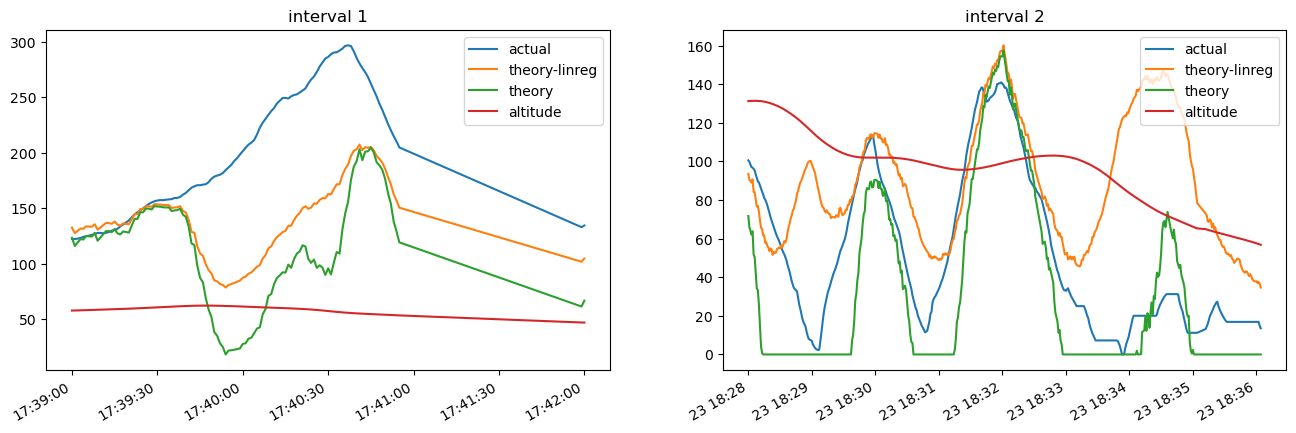

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(timestamp_test[mask_dt1], y_test[mask_dt1], label='actual')
axs[0].plot(timestamp_test[mask_dt1], y_pred[mask_dt1], label='theory-linreg')
axs[0].plot(timestamp_test[mask_dt1], y_pred_theory[mask_dt1], label='theory')
axs[0].plot(timestamp_test[mask_dt1], df23_test.loc[mask_dt1, 'enhanced_altitude'], label='altitude')
axs[0].title.set_text('interval 1')
axs[0].legend()
plt.gcf().autofmt_xdate()

axs[1].plot(timestamp_test[mask_dt2], y_test[mask_dt2], label='actual')
axs[1].plot(timestamp_test[mask_dt2], y_pred[mask_dt2], label='theory-linreg')
axs[1].plot(timestamp_test[mask_dt2], y_pred_theory[mask_dt2], label='theory')
axs[1].plot(timestamp_test[mask_dt2], df23_test.loc[mask_dt2, 'enhanced_altitude'], label='altitude')
axs[1].title.set_text('interval 2')
axs[1].legend()
plt.gcf().autofmt_xdate()

plt.show()

In the second interval the rider is going down a slope (the red line shows altitude) and is pedaling as the he needs power. The first blip in the orange line must be coming from insufficient data.
Perhaps there were strong head wind in the training data under similar conditions.

The first interval is more difficult to interpret as the green line goes down along the orange one while the rider ramped up speed. `cadence` is not a feature in the theory-based feature set. I believe augmenting the feature set will enhance accuracy.

# 1.2 NN

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'pytorch version: {torch.__version__}')
print(f'device: {device}')

pytorch version: 2.0.1
device: cpu


In [13]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super().__init__()
        l1 = nn.Linear(input_size, hidden_size1)
        a1 = nn.ReLU()
        l2 = nn.Linear(hidden_size1, output_size)
        l = [l1, a1, l2]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

## 1.2.1 NN with theory-based features

In [17]:
def standardize_tensor(np_mat):
    np_mat_norm = (np_mat - np_mat.mean())/np_mat.std()
    return torch.from_numpy(np_mat_norm.values).float()

def standardize_tensors(X_train, y_train, X_test, y_test):
    X_train_norm = standardize_tensor(X_train)
    y_train_pt = torch.from_numpy(y_train.values).float() # _pt for PyTorch

    X_test_norm = standardize_tensor(X_test)
    y_test_pt = torch.from_numpy(y_test.values).float()
    return X_train_norm, y_train_pt, X_test_norm, y_test_pt

In [18]:
seed = 42


def nn_fit(X_train, y_train, X_test, y_test, model,
           seed=42, num_epochs=100, batch_size=200, learning_rate=0.01):
    X_train_norm, y_train_pt, X_test_norm, y_test_pt = standardize_tensors(X_train, y_train, X_test, y_test)
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_ds = TensorDataset(X_train_norm, y_train_pt)
    
    
    torch.manual_seed(seed)
    train_dl = DataLoader(train_ds, batch_size)
    loss_hist = [0] * num_epochs

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_hist[epoch] += loss.item()*y_batch.size(0)
            
        loss_hist[epoch] /= len(train_dl.dataset)

    return model

In [19]:
hidden_size1 = 10
output_size = 1
model = Model(X_train_theory.shape[1], hidden_size1, output_size)

model = nn_fit(X_train_theory, y_train, X_test_theory, y_test, model, seed)

model.eval()
model.to(device)
y_pred = model(standardize_tensor(X_test_theory))[:, 0].detach().numpy()
y_pred_train = model(standardize_tensor(X_train_theory))[:, 0].detach().numpy()

errors_nn_theory = get_error_df(y_pred_train, y_train, y_pred, y_test, 'nn-theory')
errors_nn_theory

MAE          MSE
dataset                                
nn-theory_train  21.439937   783.690321
nn-theory_test   27.588691  1315.972073

NN with features determind by theory performs worse than theory-linreg. Can NN perform better with features from the original dataset?

## 1.2.2 NN with augmented features

In [28]:
keep_cols_base = [
    # 'enhanced_speed',
    'd_enhanced_speed',
    'cadence',
    'd_cadence',
    'heart_rate',
    'grade',
    'd_enhanced_altitude',
    'temperature'
]

X_train_aug = pd.concat([X_train_theory, X_train[keep_cols_base]], axis=1)
X_test_aug = pd.concat([X_test_theory, X_test[keep_cols_base]], axis=1)

hidden_size1 = 14
model = Model(X_train_aug.shape[1], hidden_size1, output_size)
model = nn_fit(X_train_aug, y_train, X_test_aug, y_test, model, seed)

model.eval()
model.to(device)
y_pred = model(standardize_tensor(X_test_aug))[:, 0].detach().numpy()
y_pred_train = model(standardize_tensor(X_train_aug))[:, 0].detach().numpy()



In [30]:
errors_nn_augmented = get_error_df(y_pred_train, y_train, y_pred, y_test, 'nn-augmented')
errors_nn_augmented

MAE          MSE
dataset                                   
nn-augmented_train  18.504273   579.444826
nn-augmented_test   25.453732  1080.107767

So performance is slightly better with the augmented features than with just the theory-based features. However it is difficult to know if the model is overfitting, 
because of the absence of required features (wind data).
We leave it as this for now as this model peforms worse than theory based linear regression.

In [32]:
plot_actual_vs_predicted_timeseries(y_pred, y_test, timestamp_test, 'nn with augmented features')

# 1.3 Gradient Boost

## 1.3.1 Gradient Boost with theory-based features


In [34]:
from sklearn.ensemble import GradientBoostingRegressor

pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingRegressor(random_state=seed))
])

pipe_gb.fit(X_train_theory, y_train)
y_pred = pipe_gb.predict(X_test_theory)

errors_gb = get_error_df(pipe_gb.predict(X_train_theory), y_train, y_pred, y_test, 'gb')
errors_gb

MAE          MSE
dataset                         
gb_train  18.945765   647.469472
gb_test   21.376869  1070.426489

Though still not as good as theory-linreg, gradient boosting shows promise as the scores above are generated using default parameters. We attempt to tune some hyperparameters:

In [36]:
params = {'gb__n_estimators': [100, 500, 1000, 2000], 'gb__max_depth': [1, 2, 3, 4, 5, 10], 'gb__learning_rate': [0.005, 0.01, 0.1, 0.5, 1] }
grid = GridSearchCV(pipe_gb, param_grid=params, scoring='neg_mean_squared_error', cv=5)
grid.fit(X_train_theory, y_train)
grid.best_params_

{'gb__learning_rate': 0.1, 'gb__max_depth': 1, 'gb__n_estimators': 500}

In [37]:
y_pred_train = grid.best_estimator_.predict(X_train_theory)
y_pred_test = grid.best_estimator_.predict(X_test_theory)

errors_gb_tuned = get_error_df(y_pred_train, y_train, y_pred, y_test, 'gb-tuned')
errors_gb_tuned

MAE          MSE
dataset                               
gb-tuned_train  19.686887   692.569039
gb-tuned_test   21.376869  1070.426489

In [ ]:
# n_cols = 3
# n_rows = int(len(X_train_theory.columns)/n_cols)
# fig, axs = plt.subplots(n_rows, n_cols)
# PartialDependenceDisplay.from_estimator(grid.best_estimator_, X_train_theory, X_train_theory.columns, ax=axs, n_cols=n_cols)
# fig.suptitle('Partial Dependence Plots')
# fig.tight_layout()

Grid searching of the GradientBoostingRegressor above took more than 10 hours to complete on my machine. It was surprising to see that it didn't do any better than linear regression with theory-based 
features. It was also surprising to see the optimal parameters - for example, given the bias we see in the model, I expected it to come up with a larger `max_depth` and larger `n_estimators`.

Further PDP (Partial Dependency Plots) analyses were planned but were not carried out, as this estimator didn't turn out better than the 'linear regression with theory-based features' model. 
I plan to take this task up in the future.

# 2 Summary of findings

Lacking critical features, this project was not as straightforward as it looked at first glance.
But I didn't know that we lacked features beforehand. I've learned this the hard way - only after seeing all the estimators fail
did I start putting serious attention to the governing equations.

That power depends on the cube of ground speed was a revelation. Which means the power required to double your speed is more than 2^3=8 times the initial power.
Not being a cyclist myself I didn't know the importance of head wind either. In case the head wind speed equals ground speed, the cubed term quadruples compared to the case when there is no head wind.
Professional cyclists striking poses to minimize their frontal area now makes perfect sense.

It was impossible to predict the tall peaks of power. Using information theory I've argued that this was one of the fundamental limitations of this project.
To improve the accuracy of predictions I've modified the target variable by computing its moving averages over 50 seconds. This turned out to be insufficient, as
the predictions still didn't catch up to the peaks. The plots in section 1.2 of part 2 depicted MAE loss (of theoretical power) converging to about 33 watts. 
It would be interesting to quantify how much of this loss is attributed to underestimating peaks. In any case, 50 seconds is a huge hit to take from a system that
aspires to provide near real time predictions.

There were predictions that went the opposite way from the actual in certain segments, like the intervals I pointed out with plots in section 1.1. 
I believe such behavior is caused by insufficient data. Specifically, I suspect that unaccounted for wind was present in the data when other features were at similar levels at 
training time. Additional data I believe most likely will remedy this situation.


Linear regression with theory-based features turned out to be the best estimator. It had 19.5 MAE. This loss is about 5% of the overall max of power, and ~19% of the mean of power.


# 3 Next steps

Below "theory-based features" refer to the features I've crafted to make use of equation (1) at the beginning of this notebook. These features were fed into our
"linear regression with theory-based features" model. "augmented features" refer to the addtion of the original features (defined by the variable `keep_cols_base` in this notebook) 
to "theory-based features".


- Add the original features to the theory-based feature set and tune the gradient boosting regressor. Grid search turned out to be extremely computationally extensive.
  
- Perform feature selection such as RFECV (Recursive Feature Elimination with CV) against the augmented feature set. There must be value to be extracted in the original features.

- Quantify the proportion of loss attributed to missing wind data.
  
- It would be interesting to examine data where absolutely no wind is present. However this will entail a professional lab setup.

- Collect more data, including data from other individuals. This project was based on data from a single individual. As such predictions here will not perform well on data from other people. 

- We've disregarded time-dependence when modeling our system.
Biological systems exhibit the property known as hysteresis, or state-dependence. 
Thus for features such as heart rate to become useful predictors, time series methods need be deployed.
RNN methods such as LSTM shall be considered.
